In [1]:
import sys
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from tqdm import tqdm
from Bio import SeqIO
from Bio.Align import substitution_matrices
from Bio import pairwise2

sys.path.append('../../')
from hamp_pred.external.lbs.sequence import mmseqs2
from hamp_pred.src.input_prep.encode import radius, phobos
from hamp_pred.src.predictor import Predictor
from hamp_pred.src.input_prep.prepare_sequence import MultiChainOperator, SeqWindow
from hamp_pred.src.input_prep.encode import RadianEncoder, MultiEncoder, OneHotEncoderSeq, RadiousPhobosEncoder
from hamp_pred.src.predictor_config import  PredictionConfig
from hamp_pred.src.models.common.models import BaseConvolutionalWrapper

2023-05-02 14:01:55.543697: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-02 14:01:55.677489: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-05-02 14:01:56.248575: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-05-02 14:01:56.248658: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [2]:
def sequence_identity(seq1, seq2):
    identical = sum(1 for a, b in zip(seq1, seq2) if a == b)
    identity = identical / len(seq1) * 100
    return identity

def sequence_similarity(seq1, seq2):
    matrix = substitution_matrices.load('blosum62')
    alignments = pairwise2.align.globalds(seq1, seq2, matrix, -10, -0.5)
    best_alignment = alignments[0]
    similarity = best_alignment[2] / best_alignment[4]
    return similarity

In [3]:
DATA_DIR = './../../data/input/'

# Load model

In [4]:
operator = MultiChainOperator(MultiEncoder([RadiousPhobosEncoder(), OneHotEncoderSeq()]), SeqWindow(11, 11), RadianEncoder(100),  SeqWindow(11, 11, null_char=[[0]]),
                                      parallel=True)
model_conf = {'activation': 'tanh',
 'norm': True,
 'n_layers': 3,
 'kernel_sizes': (3, 4, 7),
 'lstm': 2,
 'dense': 1,
 'reshape_out': False,
 'epochs': 100,
 'task': 'hamp_rot',
 'version': '3_4_7_3_2_1',
 'data_dir': '/home/users/sdunin/calc/HAMPpred/data/output/weights/hamp_rot/3_4_7_3_2_1'}

conf = PredictionConfig(BaseConvolutionalWrapper, operator, model_conf)
clf_main = Predictor('hamp_rot', config=conf, version='3_4_7_3_2_1')


### Check performance on validation set

In [5]:
data = f'{DATA_DIR}/af2_clean_model_1.p'
data = pd.read_pickle(data)

data = data[data['class'] == 'val']
data['n_seq'] = data['n_seq'].apply(lambda x: x[1:-1])
data['c_seq'] = data['c_seq'].apply(lambda x: x[1:-1])
data['sequence'] = data.apply(lambda x: x['n_seq'] + x['c_seq'], axis=1)


In [6]:
val_pred_main = clf_main.predict(data.sequence.tolist())

2023-04-28 13:22:12.468909: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-28 13:22:13.011141: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7380 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1
2023-04-28 13:22:15.830903: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8204
2023-04-28 13:22:16.076946: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-04-28 13:22:16.077301: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-04

1/1 [==============================] - 2s 2s/step


In [7]:
data['rot_main'] = val_pred_main.N_pred.apply(lambda x:np.mean(x)/2).tolist()

(-26.0, 26.0)

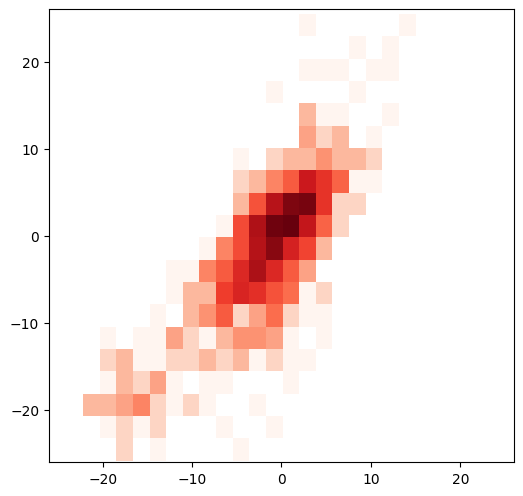

In [8]:
import matplotlib as mpl
fig, ax = plt.subplots(1,1, figsize=(6, 6), dpi=100)

ax.hist2d(data.rot_main, data.rot_mean/2, bins=20, cmap='Reds', norm=mpl.colors.LogNorm());
ax.set_xlim(-26, 26)
ax.set_ylim(-26, 26)

# Score HAMP sequences

### Get HAMP sequences

In [9]:
msa = SeqIO.parse(os.path.join(DATA_DIR, 'PF00672.alignment.full'), 'stockholm')

res = []
for s in msa:
    n_helix = str(s.seq[35:52])
    c_helix = str(s.seq[154:169])

    # uniprot MSA
    #n_helix = str(s.seq[8:50]).replace('-','')
    #c_helix = str(s.seq[183:216]).replace('-','') 
    
    n_helix_degap = n_helix.replace('-','')
    c_helix_degap = c_helix.replace('-','')
    
    if len(n_helix_degap) == len(c_helix_degap) == 13:
        res.append([n_helix_degap, c_helix_degap, s.description])
    #else:
        #print(n_helix, '   ', c_helix)
        #break
len(res)      

71152

In [10]:
data_df = pd.DataFrame(res, columns=['n_seq', 'c_seq', 'desc'])
data_df['n_seq'] = data_df['n_seq'].apply(lambda x:x[1:-1])
data_df['c_seq'] = data_df['c_seq'].apply(lambda x:x[1:-1])
assert all(data_df['n_seq'].str.len() == 11)
assert all(data_df['c_seq'].str.len() == 11)
data_df['sequence'] = data_df['n_seq'] + data_df['c_seq'] # for mmseqs2 clustering
data_df.drop_duplicates(subset = 'sequence', inplace=True)
data_df.drop(data_df[data_df.sequence.str.find('X')>-1].index, inplace=True)
len(data_df)

59456

### Score with the main model

In [11]:
#score with the main model 
res_pred = clf_main.predict(data_df.sequence.tolist())

59/59 [==============================] - 2s 18ms/step


In [12]:
data_df['rot_main'] = res_pred.N_pred.apply(lambda x:np.mean(x)/2).tolist()

In [13]:
data_df.to_pickle(os.path.join(DATA_DIR, 'scan.p'))

### Set-up

In [5]:
clusterTool = mmseqs2.MMSeqsClusterer()

In [6]:
data_df = pd.read_pickle(os.path.join(DATA_DIR, 'scan.p'))
len(data_df)

59456

### Analyses

In [7]:

data_df = clusterTool.cluster(data_df, min_identity=0.8, coverage=0.5,
                   cov_mode=0, cluster_mode=1)

createdb /tmp/akybqjei tmp/10990835140230565654/input --max-seq-len 65535 --dont-split-seq-by-len 1 --dbtype 0 --dont-shuffle 1 --id-offset 0 --compressed 0 -v 3 

Converting sequences
[=====
Time for merging files: 0h 0m 0s 21ms
Time for merging files: 0h 0m 0s 19ms
Time for merging files: 0h 0m 0s 4ms
Time for processing: 0h 0m 0s 213ms
cluster tmp/10990835140230565654/input tmp/10990835140230565654/clu tmp/10990835140230565654/clu_tmp -c 0.5 --cov-mode 0 --min-seq-id 0.8 --cluster-mode 1 

Tmp tmp/10990835140230565654/clu_tmp folder does not exist or is not a directory.
Created dir tmp/10990835140230565654/clu_tmp
Set cluster settings automatically to s=1.000000
connected component clustering produces less clusters in a single step clustering.
Please use --single-step-clusterkmermatcher tmp/10990835140230565654/input tmp/10990835140230565654/clu_tmp/3427935024038527383/linclust/661200453242525062/pref --sub-mat blosum62.out --alph-size 13 --min-seq-id 0.8 --kmer-per-seq 21 --adjust-

prefilter tmp/10990835140230565654/clu_tmp/3427935024038527383/input_step_redundancy tmp/10990835140230565654/clu_tmp/3427935024038527383/input_step_redundancy tmp/10990835140230565654/clu_tmp/3427935024038527383/pref_step0 --sub-mat blosum62.out --seed-sub-mat VTML80.out -s 1 -k 0 --k-score 2147483647 --alph-size 21 --max-seq-len 65535 --max-seqs 20 --split 0 --split-mode 2 --split-memory-limit 0 -c 0.5 --cov-mode 0 --comp-bias-corr 0 --diag-score 0 --exact-kmer-matching 0 --mask 1 --mask-lower-case 0 --min-ungapped-score 0 --add-self-matches 0 --spaced-kmer-mode 1 --db-load-mode 0 --pca 1 --pcb 1.5 --threads 20 --compressed 0 -v 3 

Using 20 threads.
Estimated memory consumption 1020 MB
Target database size: 40317 type: Aminoacid
Query database size: 40317 type: Aminoacid
Process prefiltering step 1 of 1

Index table k-mer threshold: 154 at k-mer size 6 
Index table: counting k-mers
[=================================================================] 40.32K 0s 28ms
Index table: Masked

In [8]:
def compare_sequences(seq1, seq2, method=""):
    spacer = '.' * 3
    #print('IIELSNTADKI   IGILAKSIERL')
    print(abs(seq1["rot_main"]-seq2["rot_main"]))
    print('x  da  x  d'+(" "*len(spacer))+'a  x  da  x ')
    print(f'{seq1.n_seq}{spacer}{seq1.c_seq} {np.round(seq1["rot_main"],1)} {seq1.desc}')
    r=""
    c=0
    for i,j in zip(list(seq1.n_seq+spacer+seq1.c_seq), list(seq2.n_seq+spacer+seq2.c_seq)):
        if i==j and i!=spacer[0]:
            r+='|'
        else:
            r+=' '
    print(r)
    print(f'{seq2.n_seq}{spacer}{seq2.c_seq} {np.round(seq2["rot_main"],1)} {seq2.desc}')

In [9]:
def max_ident(sequences):
    m = [0, 0, 0]
    for i in range(len(sequences)):
        for j in range(len(sequences)):
            if i>j:
                ident = (sequence_identity(sequences[i], sequences[j]))
                if ident>m[0]:
                    
                    # check if the difference is only in the core positions
                    
                    #       IIELSNTADKIIGILAKSIERL
                    #       x  da  x  da  x  da  x
                    mask = "*  **  *  **  *  **  *"
                    
                    OK=True
                    for aa1, aa2, aam in zip(list(sequences[i]), list(sequences[j]), list(mask)):
                        if aa1!=aa2 and aam!='*':
                            OK=False
                            break
                            
                            
                    if OK:
                        m = [ident, i, j]                
    return m

In [10]:
def all_ident(sequences):
    res = []
    for i in range(len(sequences)):
        for j in range(len(sequences)):
            if i>j:
                # check if the difference is only in the core positions
                
                #       a  x  da  x   x  da  x  d    
                #       EAGLAEMSRQH   AARIAKGVNEL
                #       IIELSNTADKI   IGILAKSIERL
                #       x  da  x  d   a  x  da  x
                mask = "*  **  *  *"+"*  *  **  *"

                OK=True
                mut_pos = []
                for aa1, aa2, aam, pos in zip(list(sequences[i]), 
                                              list(sequences[j]), 
                                              list(mask), 
                                              range(len(mask))):
                    
                    # we look for mutations only in the defined core positions (mask)
                    if aa1!=aa2:
                        if aam!='*':
                            OK=False
                            break
                        else:
                            mut_pos.append(pos)


                if OK:
                    ident = (sequence_identity(sequences[i], sequences[j]))
                    res.append([ident, i, j, mut_pos])
    return res

In [11]:
def compare_similar(method, MIN_CLUST_SIZE=2, mark_clusters = []):

    res = []

    for clust_id, g in (data_df.groupby('clust_id')):
        size = len(g)
        if size<MIN_CLUST_SIZE: continue

        # all-vs-all seq ident
        for seq_diff, i, j, mut_pos in all_ident(g.sequence.tolist()):
            if len(mut_pos) != 1: continue
            mut_pos_new = mut_pos[0]

            # gather data
            rot_min = g.iloc[i][f'rot_{method}'] 
            rot_max = g.iloc[j][f'rot_{method}']

            newi, newj = i,j
            if rot_min>rot_max:
                newi = j
                newj = i

            rot_diff = abs(rot_max - rot_min)
            rot_min_row = g.iloc[newi]
            rot_max_row = g.iloc[newj]  
            rot_min_desc = rot_min_row.desc.split('/')[0]
            rot_max_desc = rot_max_row.desc.split('/')[0]
            
            if clust_id in mark_clusters: 
                color = 'red'
            else:
                color = 'grey'

            res.append([clust_id, seq_diff, rot_diff, rot_min, rot_max, rot_min_row.name, rot_max_row.name, color])

    res_df = pd.DataFrame(res, columns=['clust_id', 'seq_diff', 'rot_diff', 'rot_min', 'rot_max', 
                                       'row_min_id', 'row_max_id', 'color'])
    
    
    res_df['row_min_desc'] = res_df['row_min_id'].apply(lambda x:data_df.loc[x].desc.split('/')[0])
    res_df['row_max_desc'] = res_df['row_max_id'].apply(lambda x:data_df.loc[x].desc.split('/')[0])
    
    return res_df

In [12]:
def plot_res(res_df, m_n="", bar_pos=0.98):
    title_font_size = 10
    label_font_size = 10
    tick_font_size = 8

    fig, ax = plt.subplots(1,1, figsize=(3, 7), dpi=200)
    ax.axhline(y=res_df.rot_diff.quantile(bar_pos), color='red', linestyle='--', lw=0.75)
    ax.tick_params(axis='both', which='major', labelsize=tick_font_size)
    ax.tick_params(axis='both', which='minor', labelsize=tick_font_size)

    ax.set_xlabel('', size=label_font_size)
    ax.set_ylabel(r'Absolute difference in predicted rotation [$\degree$]', size=label_font_size)
    ax.set_title("Effects of point mutations", size=title_font_size)

    sns.swarmplot(res_df, y='rot_diff', ax=ax, s=2, c=res_df.color)

    ax.set_xticks([]) 

In [13]:
mark_cluster = []
res_df_main = compare_similar(method='main', mark_clusters = mark_cluster)


In [14]:
len(res_df_main)

1442

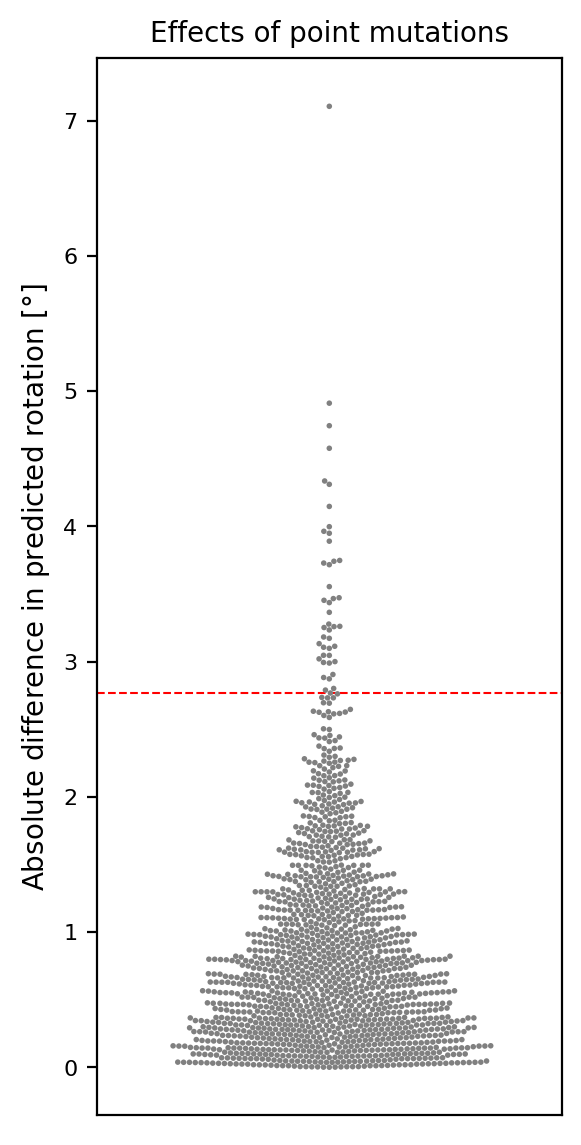

In [15]:
plot_res(res_df_main, bar_pos=0.97)

In [16]:
TOP = int(len(res_df_main)* 0.03)

for g_name, g in res_df_main.sort_values(by='rot_diff', ascending=False).head(TOP).groupby('clust_id'):

    if len(g)<2: continue
    
    print(str(g_name) + " " + '-'*50)
    
    for idx in g.index:
        pair = g.loc[idx]
        rot_min_row = data_df.loc[pair.row_min_id]
        rot_max_row = data_df.loc[pair.row_max_id]
        compare_sequences(rot_min_row, rot_max_row, 'main')

        rot_min_desc = rot_min_row.desc.split('/')[0]
        rot_max_desc = rot_max_row.desc.split('/')[0]  
        print()
        print(rot_min_desc, rot_max_desc)
        print()


552 --------------------------------------------------
3.7473034425215284
x  da  x  d   a  x  da  x 
VRNIALVTTAV...ILELKTTINTM -10.0 A0A0U3NKM6_9ACTN/471-523
|||||||||||   ||| |||||||
VRNIALVTTAV...ILEMKTTINTM -6.2 A0A563EXG1_9PSEU/630-682

A0A0U3NKM6_9ACTN A0A563EXG1_9PSEU

3.7411909265951673
x  da  x  d   a  x  da  x 
VRNIAEVTTAV...ILELKNTINTM -8.4 K9PBI3_9CYAN/655-707
|||||||||||   ||||||| |||
VRNIAEVTTAV...ILELKNTFNTM -4.6 A0A1N6G1D1_9BACT/411-463

K9PBI3_9CYAN A0A1N6G1D1_9BACT

3.72787882252173
x  da  x  d   a  x  da  x 
VRNIATVTTAV...ILELKETINTM -7.3 A0A519EQI2_9BURK/312-371
|||||||||||   ||||||| |||
VRNIATVTTAV...ILELKETFNTM -3.6 A0A4Z0BGY9_9BURK/318-370

A0A519EQI2_9BURK A0A4Z0BGY9_9BURK

3.71587459878488
x  da  x  d   a  x  da  x 
VRNIADVTTAV...ILQLKDTINTM -7.3 A0A239F2H6_9BURK/837-889
|||||||||||   ||||||| |||
VRNIADVTTAV...ILQLKDTFNTM -3.6 A0A679HUJ9_9BACT/1124-1175

A0A239F2H6_9BURK A0A679HUJ9_9BACT

3.553663513877175
x  da  x  d   a  x  da  x 
VRSIASVATAV...ILELKNTINTM -7.

<AxesSubplot: >

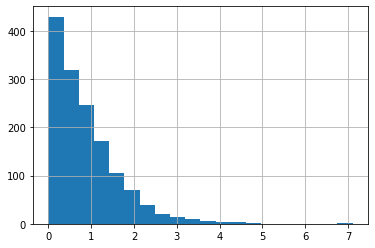

In [19]:
res_df_main.rot_diff.hist(bins=20)

In [21]:
len(res_df_main[res_df_main.rot_diff <= 2]) / len(res_df_main)

0.9167822468793343